In [1]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import time
import json
import scvi
import numpy as np

In [2]:
sc.set_figure_params(figsize=(4, 4))

In [3]:
batch_key = "condition"
cell_type_key = "final_annotation"

In [4]:
n_epochs_vae = 500
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [5]:
# Save right dir path
dir_path = os.path.expanduser(f'~/Documents/benchmarking_results/full_integration/scvi/immune_all_human_fig6/')
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [6]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/Immune_ALL_human_wo_villani_rqr_normalized_hvg.h5ad'))
adata = adata_all.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 20522 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [7]:
scvi.data.setup_anndata(adata, batch_key=batch_key)

INFO      Using batches from adata.obs["condition"]                                          
INFO      No label_key inputted, assuming all cells have same label                          
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Successfully registered anndata object containing 20522 cells, 4000 vars, 9        
          batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates  
          and 0 extra continuous covariates.                                                 
INFO      Please do not further modify adata until model is trained.                         


/home/marco/.pyenv/versions/3.7.7/envs/scvi_bench/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/marco/.pyenv/versions/3.7.7/envs/scvi_bench/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/marco/.pyenv/versions/3.7.7/envs/scvi_bench/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/marco/.pyenv/versions/3.7.7/envs/scvi_bench/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_cat

In [8]:
vae = scvi.model.SCVI(
    adata,
    n_layers=2,
    use_cuda=True,
)

In [9]:
full_time = time.time()
vae.train(n_epochs=n_epochs_vae, frequency=1, early_stopping_kwargs=early_stopping_kwargs)
full_time = time.time() - full_time

INFO      Training for 500 epochs                                                            
INFO      KL warmup for 400 epochs                                                           
Training...:  31%|███▏      | 157/500 [04:30<09:46,  1.71s/it]INFO                                                                                         
          Stopping early: no improvement of more than 0 nats in 10 epochs                    
INFO      If the early stopping criterion is too strong, please instantiate it with different
          parameters in the train method.                                                    
Training...:  31%|███▏      | 157/500 [04:32<09:54,  1.73s/it]
INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO      Training time:  200 s. / 500 epochs                                                


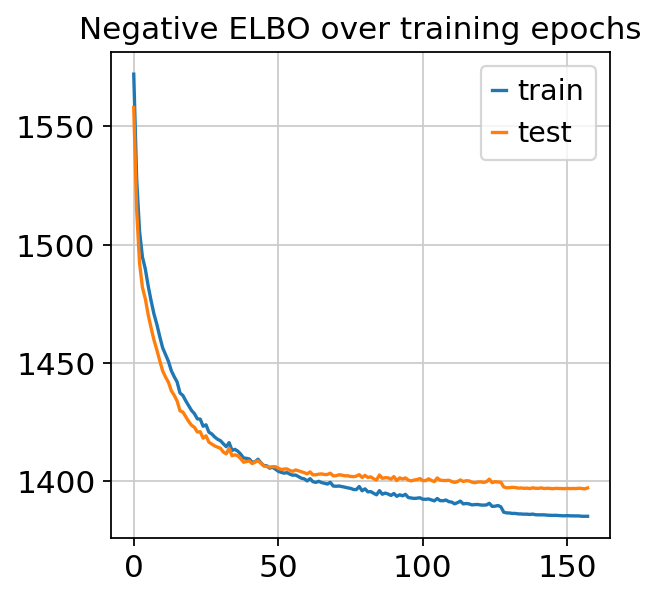

In [10]:
plt.plot(vae.trainer.history["elbo_train_set"][2:], label="train")
plt.plot(vae.trainer.history["elbo_test_set"][2:], label="test")
plt.title("Negative ELBO over training epochs")
plt.legend()

In [11]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

<Figure size 320x320 with 0 Axes>

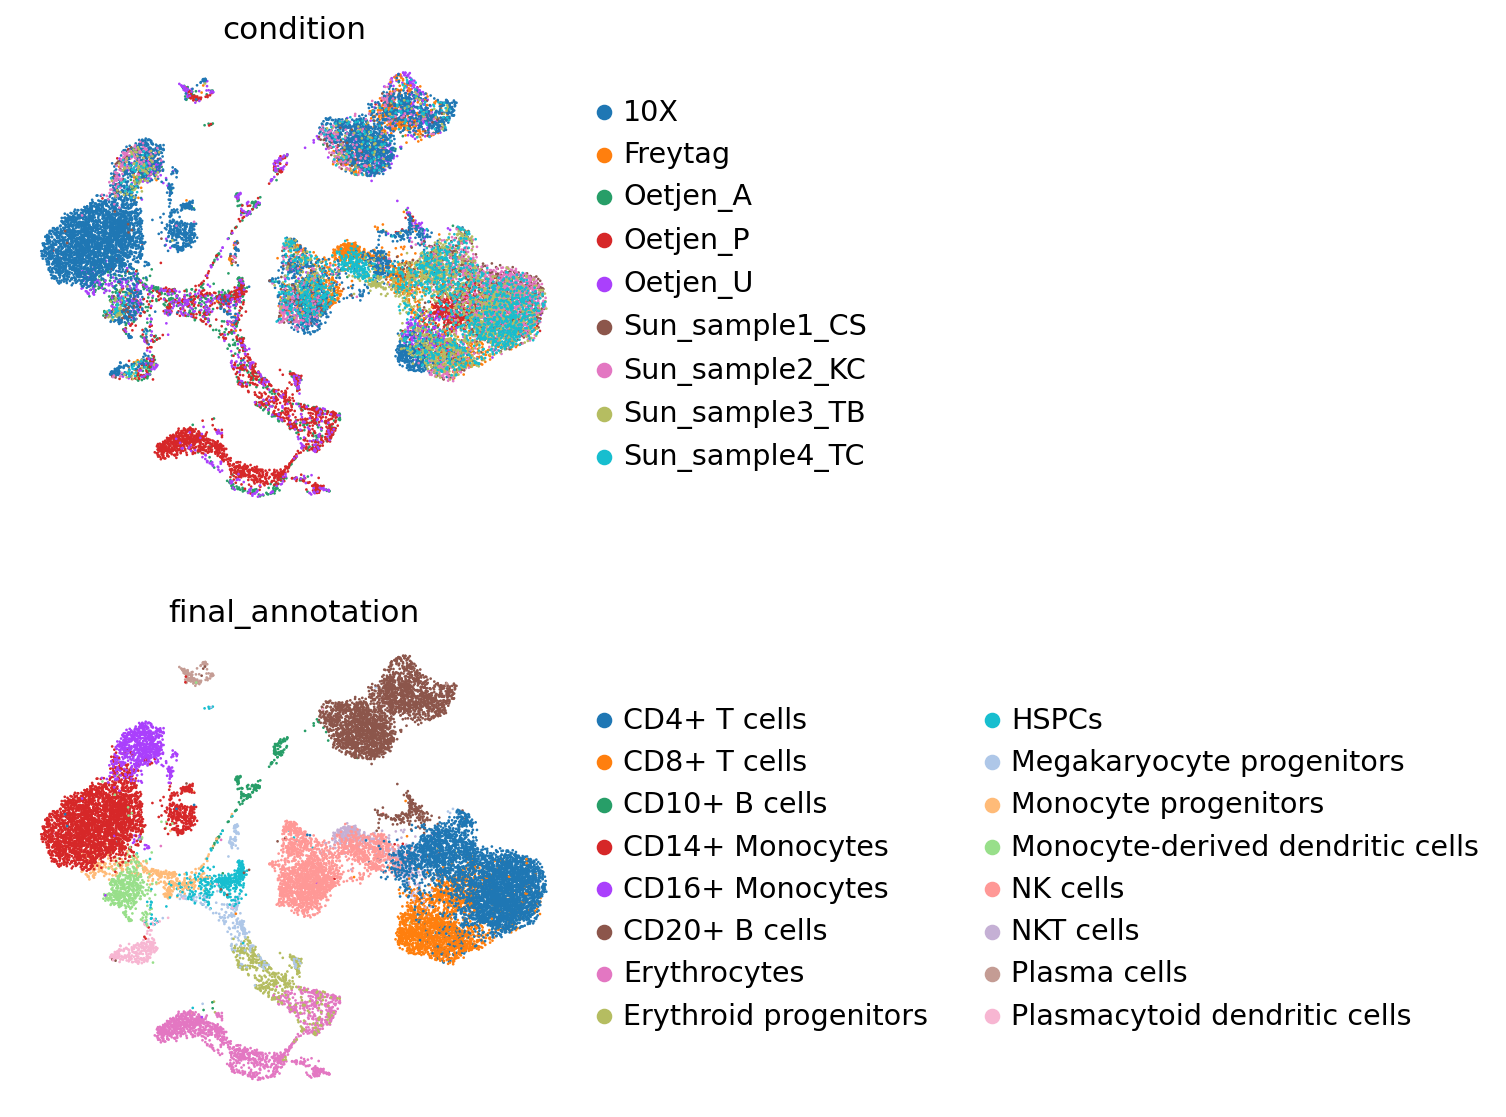

In [12]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)
plt.figure()
sc.pl.umap(
    adata,
    color=[batch_key, cell_type_key],
    frameon=False,
    ncols=1,
)

In [13]:
adata.write_h5ad(filename=f'{dir_path}data.h5ad')
torch.save(vae.model.state_dict(), f'{dir_path}model_state_dict')
path = f'{dir_path}model/'
if not os.path.exists(path):
    os.makedirs(path)
vae.save(path, overwrite=True)

In [14]:
times = dict()
times["full_time"] = full_time
with open(f'{dir_path}results_times.txt', 'w') as filehandle:
    json.dump(times, filehandle)